# Fair Weather Pedalers
Harvard APMA-E207/AM207 Spring 2016 final project
Kevin Burek <kevin.burek@gmail.com> and Josh Mclellan <jvl.mclellan@gmail.com>

## Preliminary visualizations of Hubway ride data

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import datetime as dt

In [34]:
trips_csv = '../data/hubway_2011_07_through_2013_11/hubway_trips.csv'
trips_csv = '../data/hubway_2011_07_through_2013_11/fewer_hubway_trips.csv'
#trips_csv = '../data/hubway_2011_07_through_2013_11/fewest_hubway_trips.csv'

ride_data = np.genfromtxt(trips_csv, delimiter=',')
ride_df = pd.read_csv(trips_csv)

In [35]:
ride_df.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23,7/28/2011 10:12:00,23,B00468,Registered,'97217,1976,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23,7/28/2011 10:25:00,23,B00554,Registered,'02215,1966,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23,7/28/2011 10:34:00,23,B00456,Registered,'02108,1943,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23,7/28/2011 10:36:00,23,B00554,Registered,'02116,1981,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23,7/28/2011 10:37:00,23,B00554,Registered,'97214,1983,Female


### Adding calculated columns
In order to analyze the data easily, we need to add some columns to the data frame that extract deterministic properties of the data rows.  Such as day of week and hour of day, from the otherwise plaintext start_date and end_date columns. 

In [36]:
# Figure out how to parse an example time value.
egtime = ride_df['start_date'][0]
import dateutil.parser as dtp
time = dtp.parse(egtime)

for endpoint in ('start', 'end'):
    weekdays = [dtp.parse(d).weekday() for d in ride_df[endpoint + '_date']]
    ride_df.loc[:,endpoint + '_weekday'] = pd.Series(weekdays, index = ride_df.index)
    daytimes = [dtp.parse(d).time() for d in ride_df[endpoint + '_date']]
    ride_df.loc[:,endpoint + '_time'] = pd.Series(daytimes, index = ride_df.index)

In [37]:
ride_df.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,start_weekday,start_time,end_weekday,end_time
0,1,8,Closed,9,7/28/2011 10:12:00,23,7/28/2011 10:12:00,23,B00468,Registered,'97217,1976,Male,3,10:12:00,3,10:12:00
1,2,9,Closed,220,7/28/2011 10:21:00,23,7/28/2011 10:25:00,23,B00554,Registered,'02215,1966,Male,3,10:21:00,3,10:25:00
2,3,10,Closed,56,7/28/2011 10:33:00,23,7/28/2011 10:34:00,23,B00456,Registered,'02108,1943,Male,3,10:33:00,3,10:34:00
3,4,11,Closed,64,7/28/2011 10:35:00,23,7/28/2011 10:36:00,23,B00554,Registered,'02116,1981,Female,3,10:35:00,3,10:36:00
4,5,12,Closed,12,7/28/2011 10:37:00,23,7/28/2011 10:37:00,23,B00554,Registered,'97214,1983,Female,3,10:37:00,3,10:37:00


In [40]:
from numpy import array as A
ride_seconds = [(t.hour*60 + t.minute)*60 + t.second for t in ride_df['start_time']]

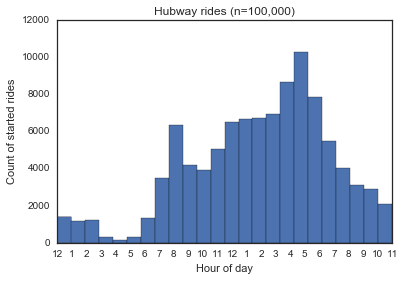

In [63]:
plt.hist(ride_seconds, bins=24)
plt.xlim((0, 24*3600))
plt.xticks(np.linspace(0,24*3600, 24))
plt.gca().set_xticklabels((np.arange(0,24,1) % 12 + 1)[(11,0,1,2,3,4,5,6,7,8,9,10)*2,])
plt.title("Hubway rides (n=100,000)")
plt.xlabel("Hour of day")
plt.ylabel("Count of started rides")
plt.show()